In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

# データ整形
2013年9月26日の1:100の株式分割を調整したデータを用いる

In [2]:
df = pd.read_csv("9501_2003.csv", encoding='cp932', header=1)
for i in range(16):
    year = i+2004
    temp = pd.read_csv(f"9501_{year}.csv", encoding='cp932', header=1)
    df = pd.concat((df,temp),axis=0)
df = df.reset_index(drop=True)

In [3]:
df.tail()

,日付,始値,高値,安値,終値,出来高,終値調整値
4137,2019-11-26,477,480,473,474,8370000,474
4138,2019-11-27,474,486,474,485,6916300,485
4139,2019-11-28,487,489,480,482,5982300,482
4140,2019-11-29,482,487,479,480,4885500,480
4141,2019-12-02,480,487,479,483,5306700,483


マーケット株価としてTOPIXを採用する。

In [4]:
topix = pd.read_csv("topix.csv").rename(columns={'終値': 'TOPIX終値', '日付': 'TOPIX日付'})

In [5]:
for i in range(len(topix)):
    if (i%22 == 20) or (i%22 == 21):
        topix.drop(i, inplace=True)
topix = topix[::-1].reset_index(drop=True)
topix_copy = topix.copy()
topix.drop([3380,3382,3647,4090], axis=0, inplace=True)
topix = topix.reset_index(drop=True)

In [6]:
topix.head()

,TOPIX日付,始値,高値,安値,TOPIX終値
0,2003/01/06,851.8,862.19,851.8,860.07
1,2003/01/07,868.32,870.69,853.93,853.93
2,2003/01/08,850.05,850.05,839.55,839.55
3,2003/01/09,832.69,839.33,829.69,839.33
4,2003/01/10,843.31,843.83,830.92,837.7


無リスク資産として、日本国債（10年）を採用する

In [7]:
bond = pd.read_csv("bond.csv")
bond.drop([3380,3382,3647,4090], axis=0, inplace=True)
bond = bond.reset_index(drop=True)

In [8]:
bond.tail()

,国債日付,金利
4137,2019/11/26,-0.092
4138,2019/11/27,-0.106
4139,2019/11/28,-0.086
4140,2019/11/29,-0.075
4141,2019/12/02,-0.046


In [9]:
date = pd.concat((df["日付"].str.replace('-',''),bond["国債日付"].str.replace('/','')),axis=1)
date.fillna(0,inplace=True)
date = date.astype(int)
for i in range(len(date)):
    if date.loc[i,"日付"]!=date.loc[i,"国債日付"]:
        print(i)

In [10]:
#date.loc[4142-1:4142]

In [11]:
#topix_copy[4087-1:4087+5]

In [12]:
df.shape, topix.shape, bond.shape

((4142, 7), (4142, 5), (4142, 2))

In [13]:
df = pd.concat((df,topix["TOPIX終値"].astype(float)),axis=1)
df = pd.concat((df,bond["金利"].astype(float)),axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4142 entries, 0 to 4141
Data columns (total 9 columns):
日付         4142 non-null object
始値         4142 non-null int64
高値         4142 non-null int64
安値         4142 non-null int64
終値         4142 non-null int64
出来高        4142 non-null int64
終値調整値      4142 non-null int64
TOPIX終値    4142 non-null float64
金利         4142 non-null float64
dtypes: float64(2), int64(6), object(1)
memory usage: 291.3+ KB


In [15]:
df["日足収益率"] = df["終値調整値"].diff()
df["TOPIX日足利益率"] = df["TOPIX終値"].diff()
df["日足収益率"][:-1] = df["日足収益率"][1:]
df["TOPIX日足利益率"][:-1] = df["TOPIX日足利益率"][1:]
df["日足収益率"] = df["日足収益率"]/df["終値調整値"]
df["TOPIX日足利益率"] = df["TOPIX日足利益率"]/df["TOPIX終値"]
df["日足収益率"][1:] = df["日足収益率"][:-1]
df["TOPIX日足利益率"][1:] = df["TOPIX日足利益率"][:-1]
df["日足収益率"][0:1]=np.nan
df["TOPIX日足利益率"][0:1]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [16]:
df["週足収益率"] = df["終値調整値"].diff(7)
df["TOPIX週足利益率"] = df["TOPIX終値"].diff(7)
df["週足収益率"][:-7] = df["週足収益率"][7:]
df["TOPIX週足利益率"][:-7] = df["TOPIX週足利益率"][7:]
df["週足収益率"] = df["週足収益率"]/df["終値調整値"]
df["TOPIX週足利益率"] = df["TOPIX週足利益率"]/df["TOPIX終値"]
df["週足収益率"][7:] = df["週足収益率"][:-7]
df["TOPIX週足利益率"][7:] = df["TOPIX週足利益率"][:-7]
df["週足収益率"][0:7]=np.nan
df["TOPIX週足利益率"][0:7]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [17]:
df["月間収益率"] = df["終値調整値"].diff(30)
df["TOPIX月間利益率"] = df["TOPIX終値"].diff(30)
df["月間収益率"][:-30] = df["月間収益率"][30:]
df["TOPIX月間利益率"][:-30] = df["TOPIX月間利益率"][30:]
df["月間収益率"] = df["月間収益率"]/df["終値調整値"]
df["TOPIX月間利益率"] = df["TOPIX月間利益率"]/df["TOPIX終値"]
df["月間収益率"][30:] = df["月間収益率"][:-30]
df["TOPIX月間利益率"][30:] = df["TOPIX月間利益率"][:-30]
df["月間収益率"][0:30]=np.nan
df["TOPIX月間利益率"][0:30]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [18]:
df.tail()

,日付,始値,高値,安値,終値,出来高,終値調整値,TOPIX終値,金利,日足収益率,TOPIX日足利益率,週足収益率,TOPIX週足利益率,月間収益率,TOPIX月間利益率
4137,2019-11-26,477,480,473,474,8370000,474,1705.71,-0.092,0.002114,0.001615,-0.038540,0.005328,-0.122222,0.078594
4138,2019-11-27,474,486,474,485,6916300,485,1710.98,-0.106,0.023207,0.003090,-0.008180,0.006033,-0.091760,0.072533
4139,2019-11-28,487,489,480,482,5982300,482,1708.06,-0.086,-0.006186,-0.001707,-0.012295,0.006678,-0.107407,0.054228
4140,2019-11-29,482,487,479,480,4885500,480,1699.36,-0.075,-0.004149,-0.005093,0.002088,0.004878,-0.112754,0.041587
4141,2019-12-02,480,487,479,483,5306700,483,1714.49,-0.046,0.006250,0.008903,0.010460,0.014863,-0.092105,0.055616


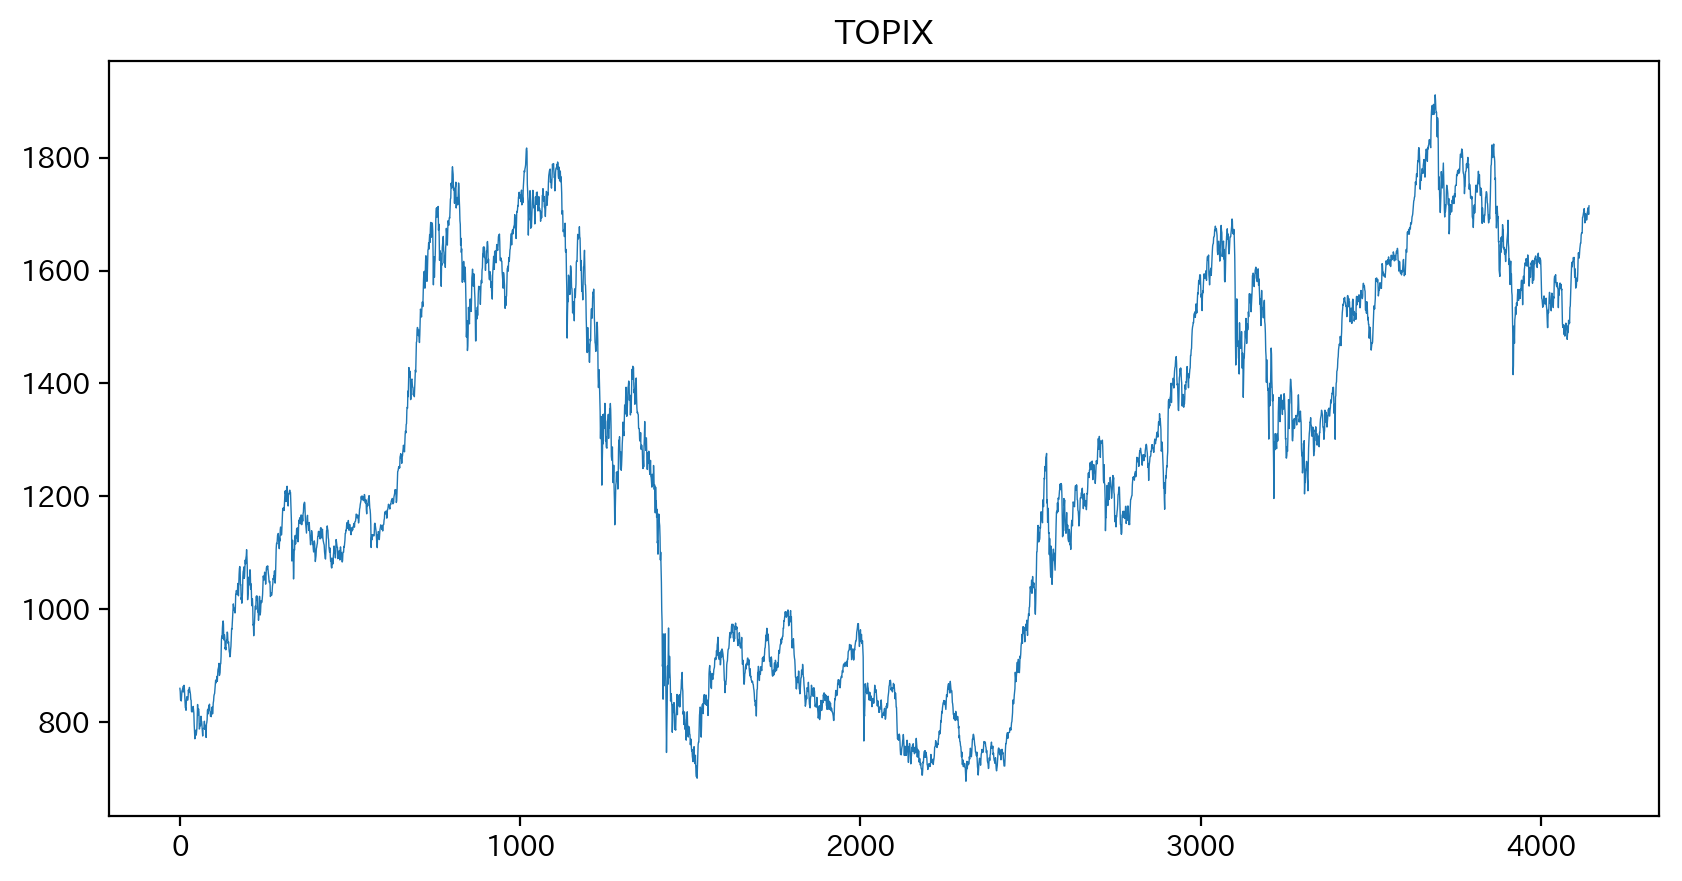

In [19]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"TOPIX")
plt.plot(df["TOPIX終値"], linewidth=0.5)

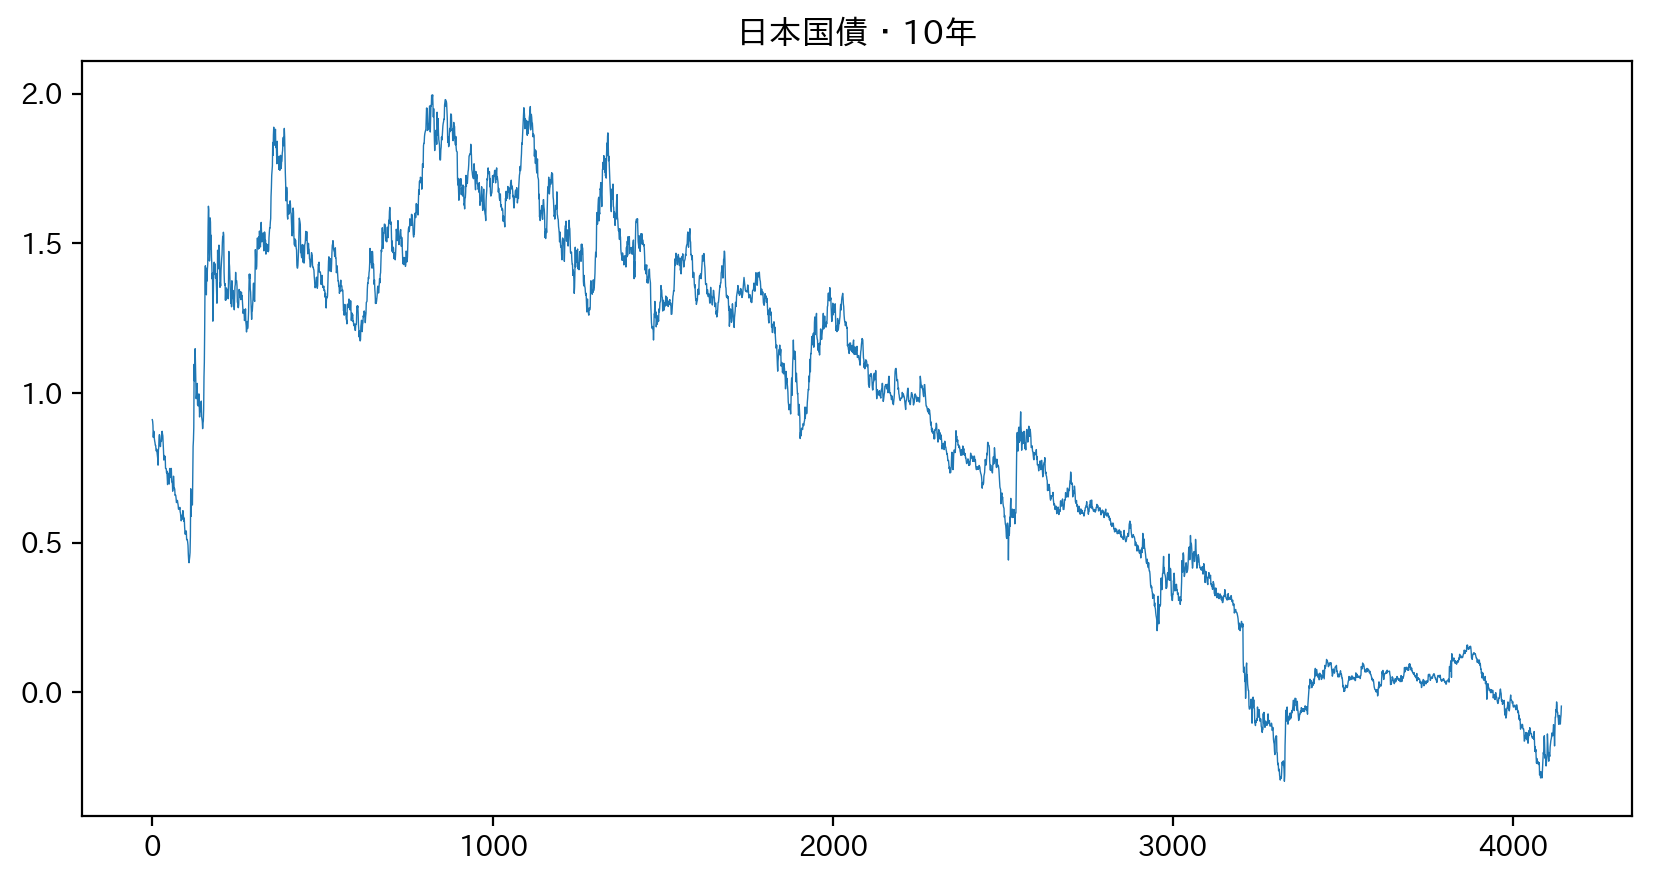

In [20]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"日本国債・10年")
plt.plot(df["金利"], linewidth=0.5)

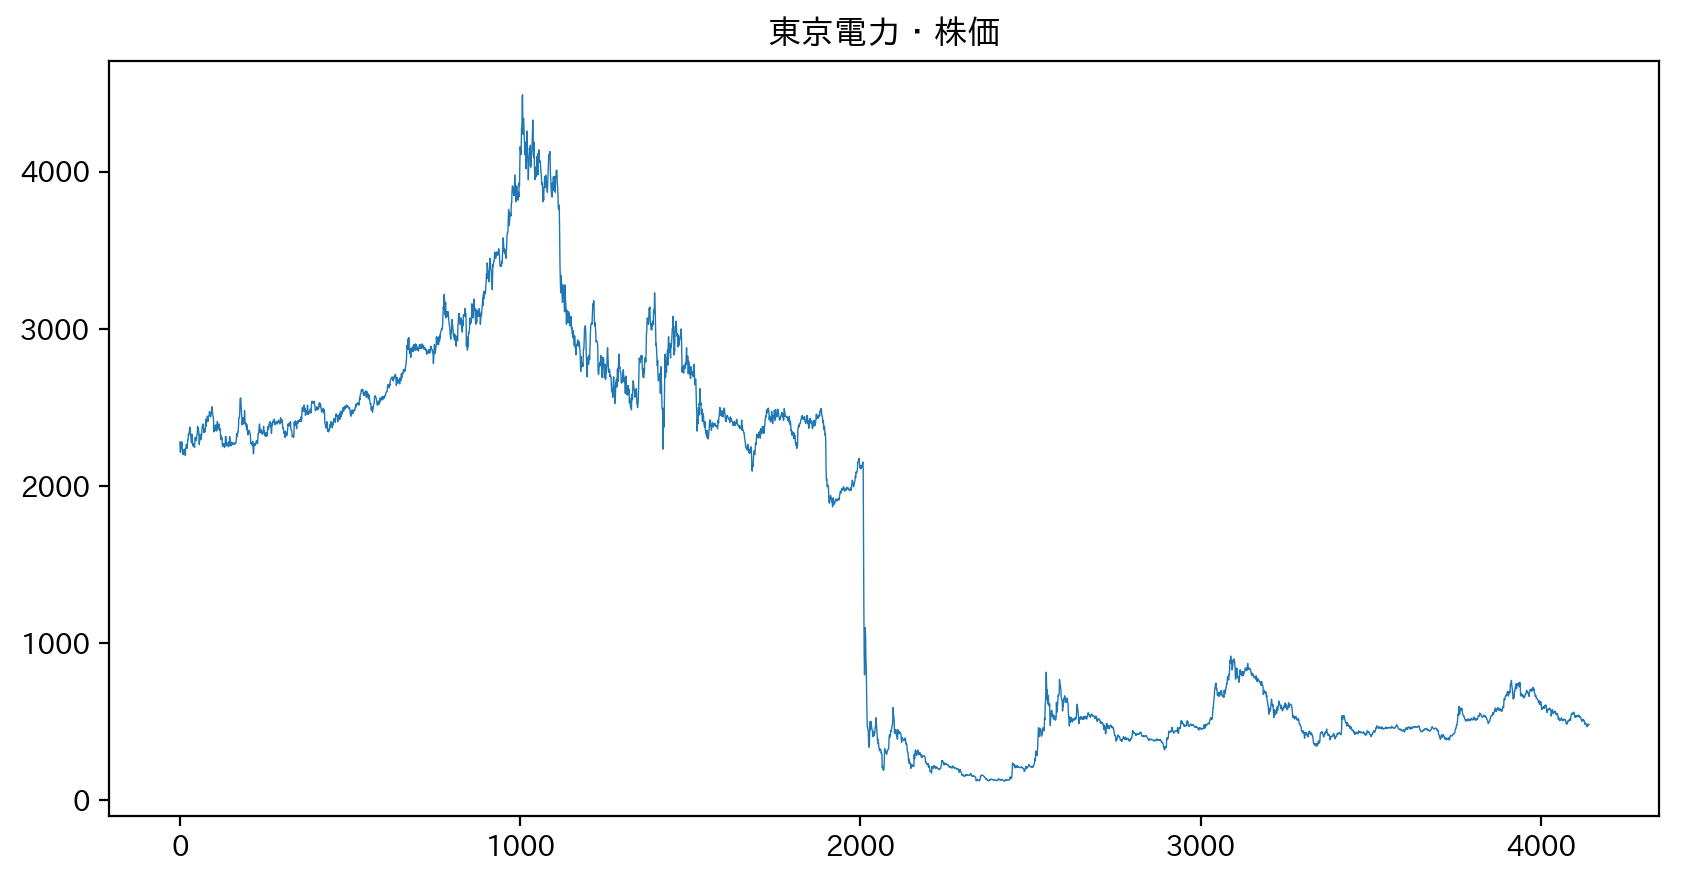

In [21]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"東京電力・株価")
plt.plot(df["終値調整値"], linewidth=0.5)

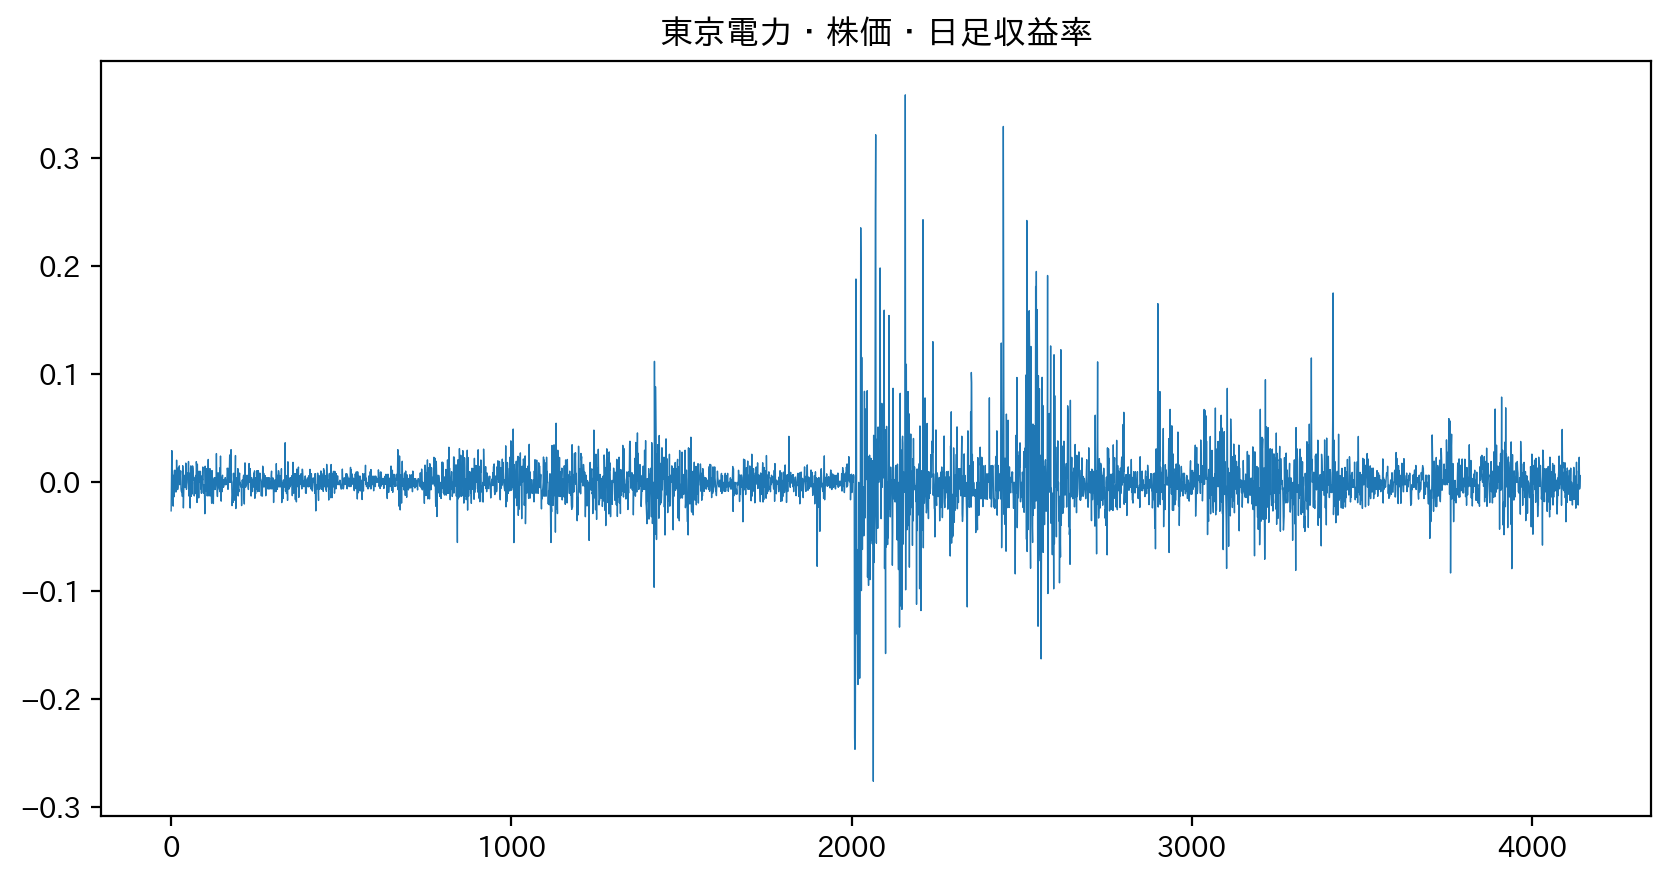

In [22]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"東京電力・株価・日足収益率")
plt.plot(df["日足収益率"][1:], linewidth=0.5)

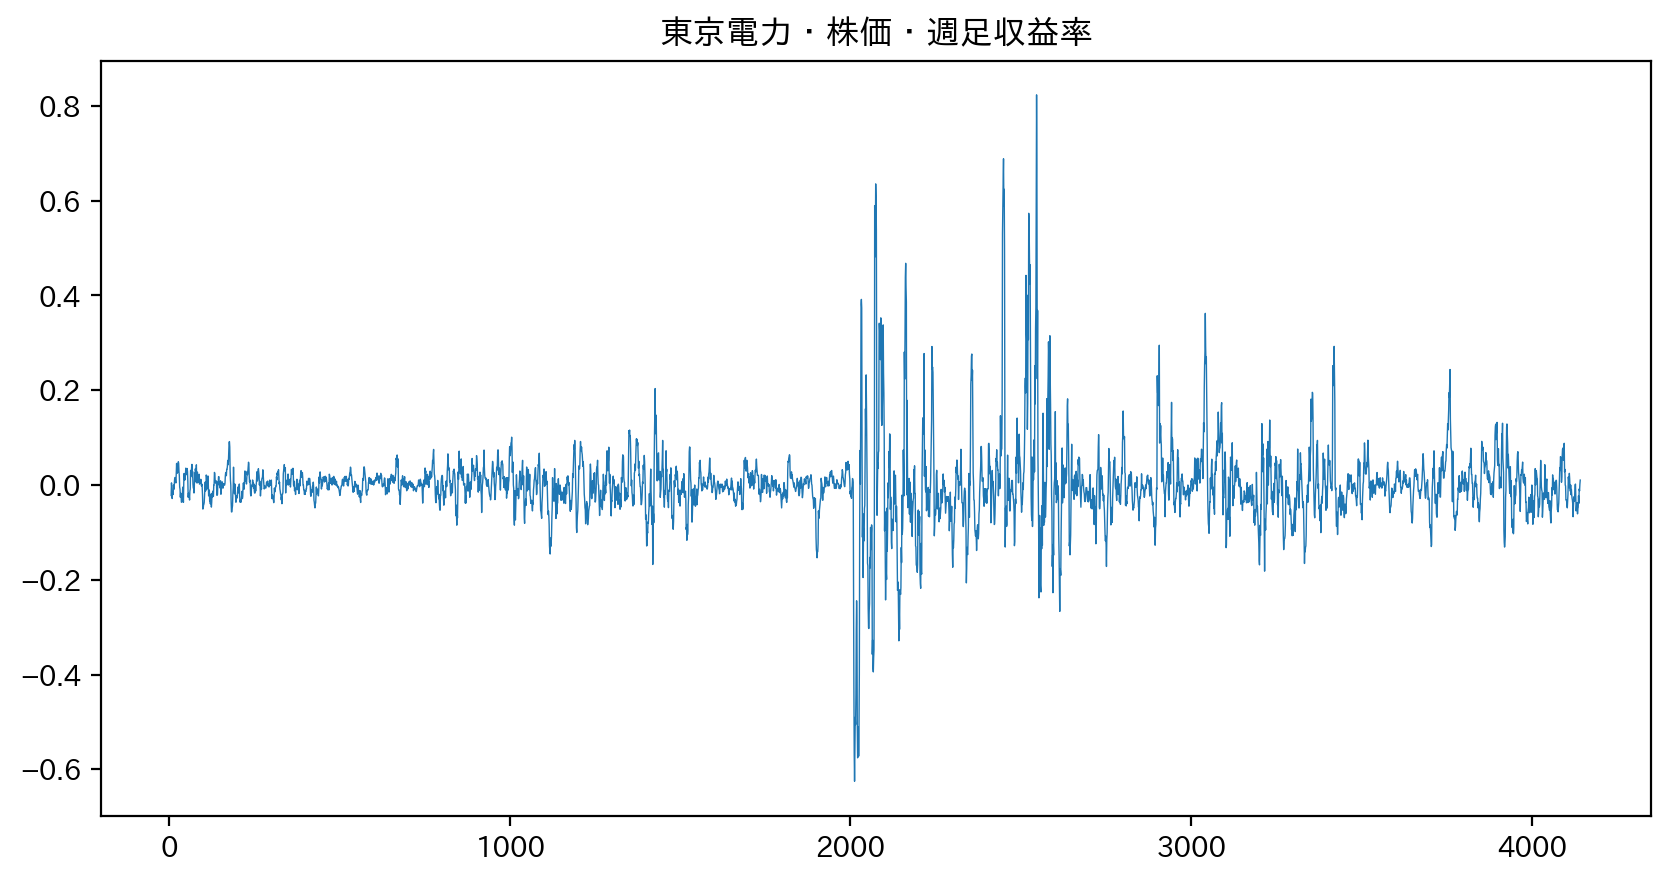

In [23]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"東京電力・株価・週足収益率")
plt.plot(df["週足収益率"][7:], linewidth=0.5)

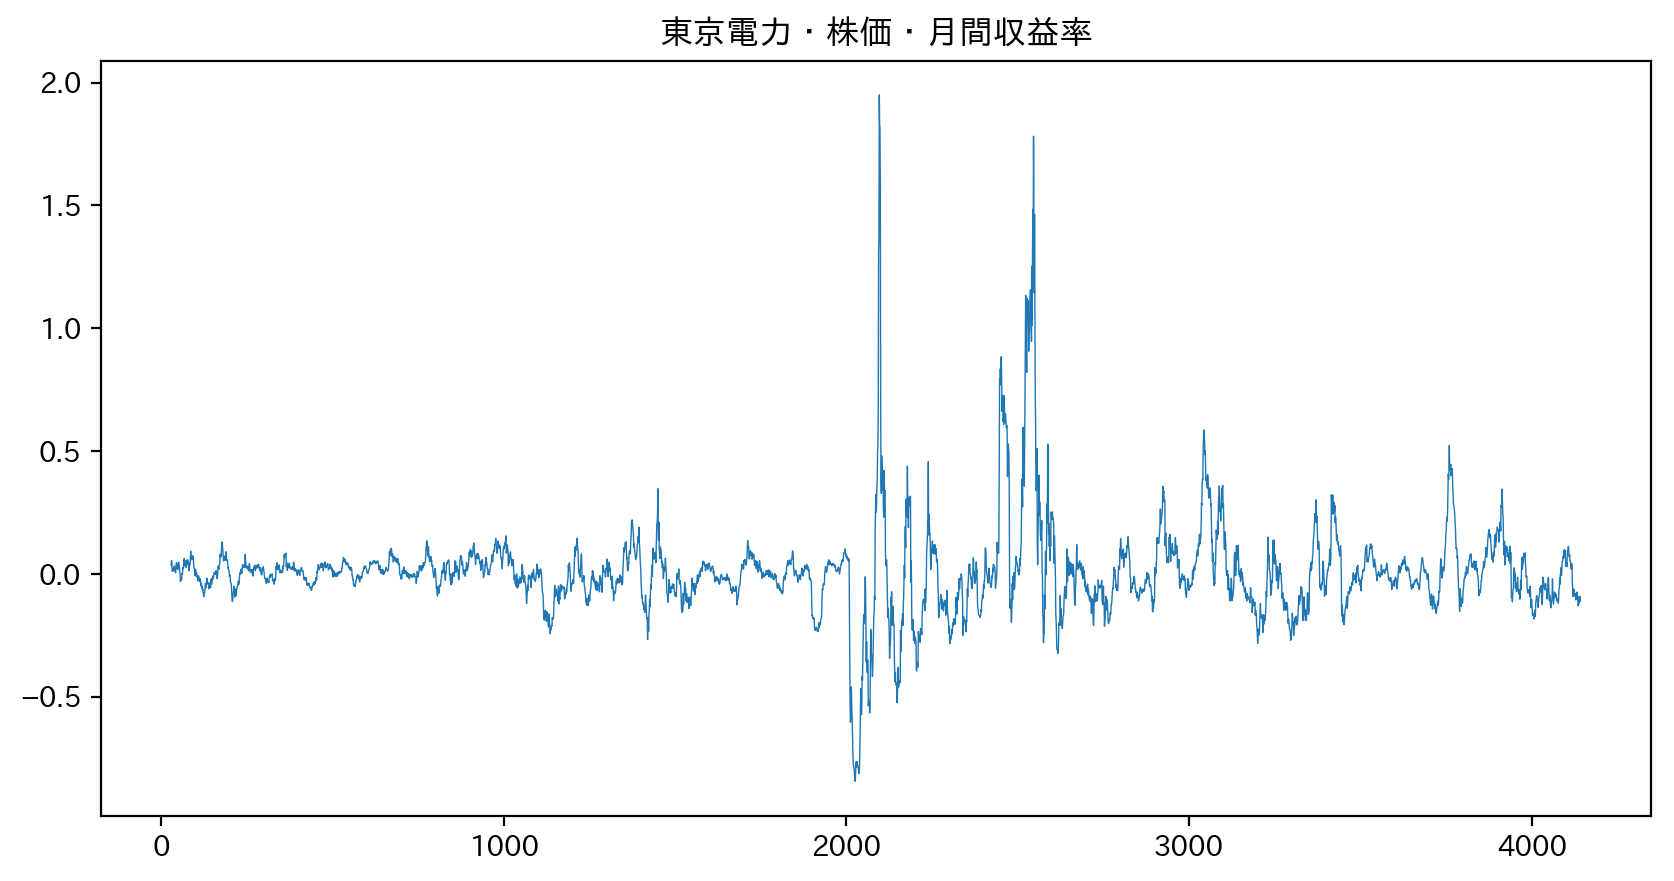

In [24]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"東京電力・株価・月間収益率")
plt.plot(df["月間収益率"][30:], linewidth=0.5)

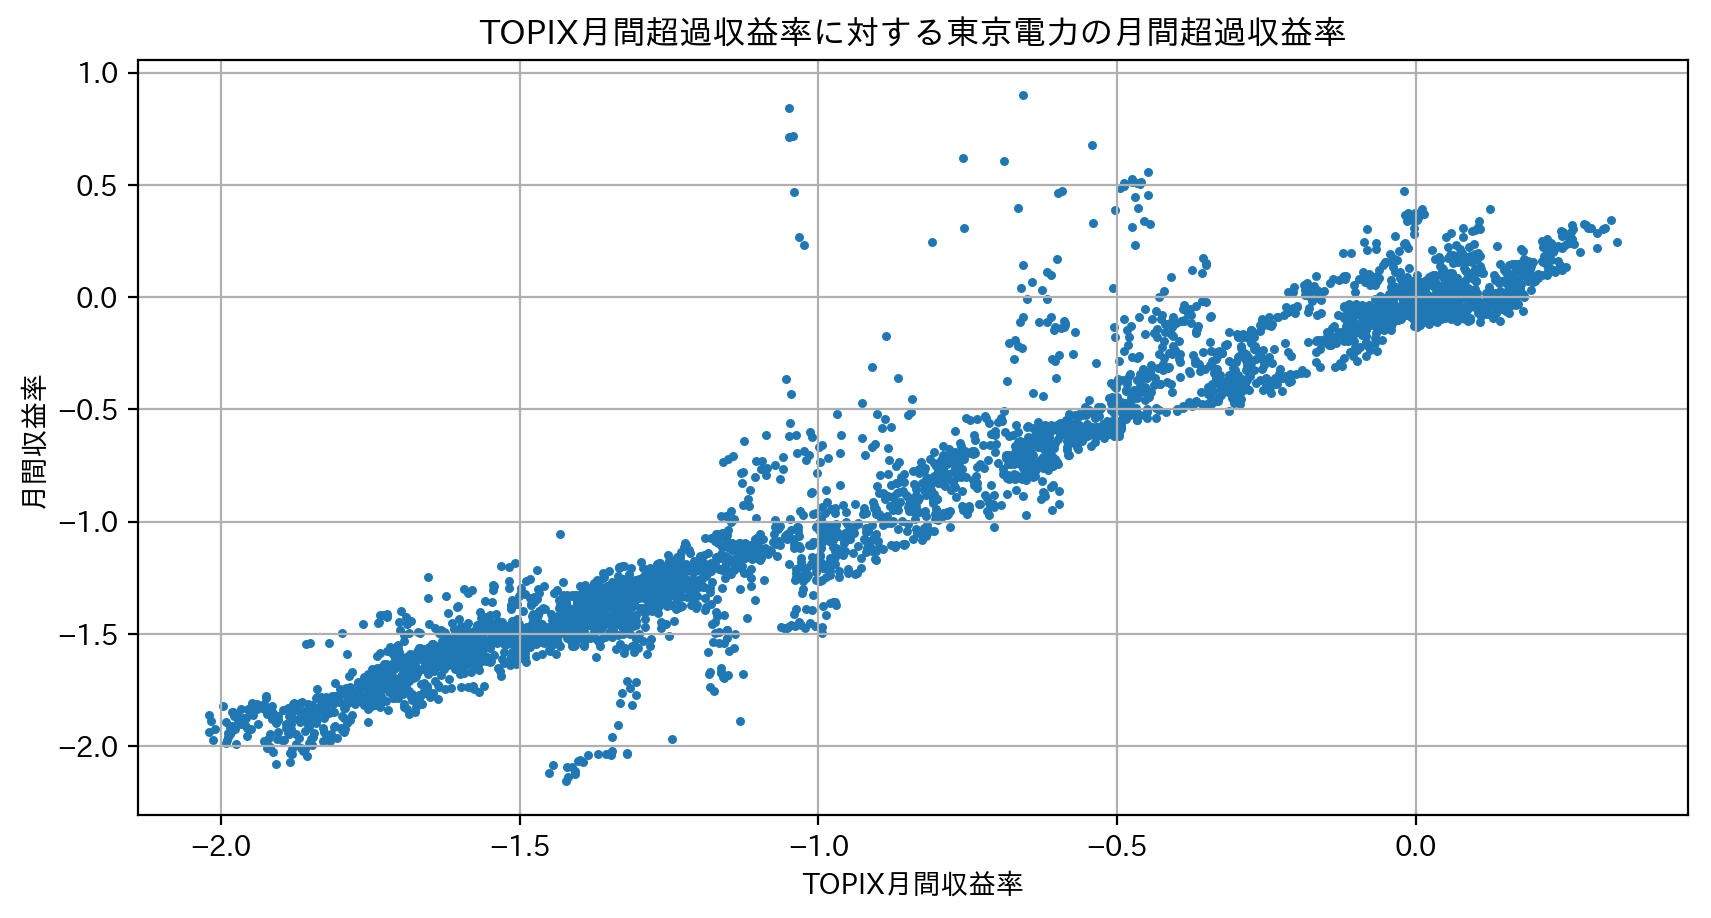

In [25]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"TOPIX月間超過収益率に対する東京電力の月間超過収益率")
plt.scatter(df["TOPIX月間利益率"][30:]-df["金利"][30:],df["月間収益率"][30:]-df["金利"][30:], s=5)
plt.xlabel('TOPIX月間収益率')
plt.ylabel('月間収益率')
plt.grid()
plt.show()

In [26]:
x = df["月間収益率"][30:]-df["金利"][30:]
length = len(x)

In [27]:
x.shape

(4112,)

In [28]:
x.mean()

-0.878935369191577

In [29]:
x.std()

0.6588274350689143

# MCMC

In [30]:
epsilon = 0.01
# 
trial = 25000
# trial: how many times do mcmc

In [31]:
theta = [0.8,1.2,0.01,0.1,1,1,0,0]
theta[6] = np.exp(theta[4])/(1+np.exp(theta[4]))
theta[7] = np.exp(theta[5])/(1+np.exp(theta[5]))
# theta[0] = mu1
# theta[1] = mu2
# theta[2] = sigma1
# theta[3] = sigma2
# theta[4] = p0
# theta[5] = q0
# theta[6] = p
# theta[7] = q

num_val = len(theta)

対数尤度を計算する関数

In [32]:
excess_return = df["TOPIX月間利益率"][30:]-df["金利"][30:]

In [33]:
def cal_logL(x, theta):
    likelihood1 = stats.norm.pdf(x=x, loc=theta[0]*excess_return, scale=np.sqrt(theta[2]))
    likelihood2 = stats.norm.pdf(x=x, loc=theta[1]*excess_return, scale=np.sqrt(theta[3]))
    
    prior1=(1-theta[7])/(2-theta[6]-theta[7])
    prior2=(1-theta[6])/(2-theta[6]-theta[7])
    
    logL = 0
    for i in range(length):
        temp1 = likelihood1[i]*prior1
        temp2 = likelihood2[i]*prior2
        
        if (temp1 == 0) & (temp2 == 0):
            temp1 +=  10**(-100)
            temp2 +=  10**(-100)
            
        posterior1 = temp1/(temp1+temp2)
        posterior2 = temp2/(temp1+temp2)

        logL += np.log(temp1+temp2)
        
        prior1 = theta[6]*posterior1 + (1-theta[7])*posterior2
        prior2 = (1-theta[6])*posterior1 + theta[7]*posterior2
        
    return logL

各レジームである確率の配列を返す関数

In [34]:
def prob_regime(x, theta):
    likelihood1 = stats.norm.pdf(x=x, loc=theta[0], scale=np.sqrt(theta[2]))
    likelihood2 = stats.norm.pdf(x=x, loc=theta[1], scale=np.sqrt(theta[3]))
    
    prior1=(1-theta[7])/(2-theta[6]-theta[7])
    prior2=(1-theta[6])/(2-theta[6]-theta[7])
    
    prob_list1 = []
    prob_list2 = []
    for i in range(length):
        temp1 = likelihood1[i]*prior1
        temp2 = likelihood2[i]*prior2
        
        if (temp1 == 0) & (temp2 == 0):
            temp1 +=  10**(-100)
            temp2 +=  10**(-100)
            
        prob_list1.append(temp1/(temp1+temp2))
        prob_list2.append(temp2/(temp1+temp2))
        
        posterior1 = temp1/(temp1+temp2)
        posterior2 = temp2/(temp1+temp2)
        
        prior1 = theta[6]*posterior1 + (1-theta[7])*posterior2
        prior2 = (1-theta[6])*posterior1 + theta[7]*posterior2
    
    return prob_list1, prob_list2

$\theta$を更新する関数。  
レジーム1よりレジーム2のボラティリティが大きいことを条件としている。

In [35]:
def create_next_theta(theta, epsilon):
    new_theta = theta.copy()
    new_theta[0:6] += (2*np.random.rand(6)-1)*epsilon
    new_theta[2:4] = np.exp(np.log(theta[2:4]) + (2*np.random.rand(2)-1)*epsilon)
    
    if new_theta[0]>new_theta[1]:
        new_theta[0] = theta[0]
        new_theta[1] = theta[1]

    new_theta[6] = np.exp(new_theta[4])/(1+np.exp(new_theta[4]))
    new_theta[7] = np.exp(new_theta[5])/(1+np.exp(new_theta[5]))
    
    return list(new_theta)

MCMCを実行する関数

In [36]:
def mcmc(x, theta, trial):
    # x: time_series
    # theta: parameter
    # trial: how many times do mcmc
    
    theta_list = []
    logL_list = []
    theta_list.append(theta)
    
    for i in tqdm(range(trial)):
        next_theta = create_next_theta(theta, epsilon)
        
        logL = cal_logL(x, theta)
        next_logL = cal_logL(x, next_theta)
        
        ratio = np.exp(next_logL-logL)
        logL_list.append(logL)

        if ratio > 1:
            theta = next_theta

        elif ratio > np.random.rand():
            theta = next_theta

        theta_list.append(theta)
        
        #if np.abs(np.log(ratio)) < 10**(-8):
            #return theta_list
        
        #if (i <120) & (i%4==0):
        if (False):
            prob1, prob2 = prob_regime(x, theta)
            regime = np.array(prob2)>=0.5
            regime = regime.astype(int)

            fig = plt.figure(figsize=(10,5),dpi=200)
            ax1 = fig.add_subplot(111)
            ln1=ax1.plot(range(length), x, linewidth=0.7, color="black", label="data")

            ax2 = ax1.twinx()
            ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
            ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

            h1, l1 = ax1.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

            ax1.set_xlabel('t')
            ax1.set_ylabel(r'data')
            ax2.set_ylabel(r'$P(I(t) = 2)$')
            ax1.set_title(f"Estimated Regime, epsilon={epsilon}, trial={i}/{trial}")
            plt.savefig(f'regime_estimating_{i}.png')
            
        if i%100==0:
            print(logL)
    
    return theta_list, logL_list

### 実行

In [37]:
theta_list, logL_list = mcmc(x, theta, trial)

-254.3051161803305
2364.843071778955
2565.636122897437
2642.030003059008
2736.6983186239786
2855.7937846191517
2930.877657178086
3019.2787812490633
3096.575149853525
3139.6645900393164
3197.8939459397343
3248.861948792953
3280.599522842416
3284.000965713224
3306.2473046515597
3323.4017088860496
3326.2870060336145
3346.3702487082205
3360.1169717552175
3364.8971150485168
3392.706561382813
3421.353402332586
3440.717383173108
3451.762812684913
3468.112609325167
3476.029891041651
3491.6922312480515
3499.758091689136
3509.096143351083
3517.7754677912185
3518.070414431351
3527.5357775333096
3538.743974493121
3550.559451682047
3553.264771284019
3558.9237678042355
3563.2131603893295
3569.099980560624
3577.9391477068134
3583.171992758667
3592.8703810057623
3592.4535467133364
3593.336569229878
3595.3721260152543
3594.242629493435
3596.2831111044243
3598.639160276456
3602.722294743726
3601.6198406043827
3606.8322676614885
3608.816906961646
3609.9562823222764
3611.03415702879
3613.708957017914
3614

In [38]:
theta_list = np.array(theta_list)

In [49]:
theta_list[-1]

array([1.00239236e+00, 1.02631101e+00, 3.61055423e-03, 1.04976531e-01,
       4.35870144e+00, 3.23086089e+00, 9.87366652e-01, 9.61979253e-01])

In [39]:
prob1, prob2 = prob_regime(x, theta_list[-1])

### 可視化

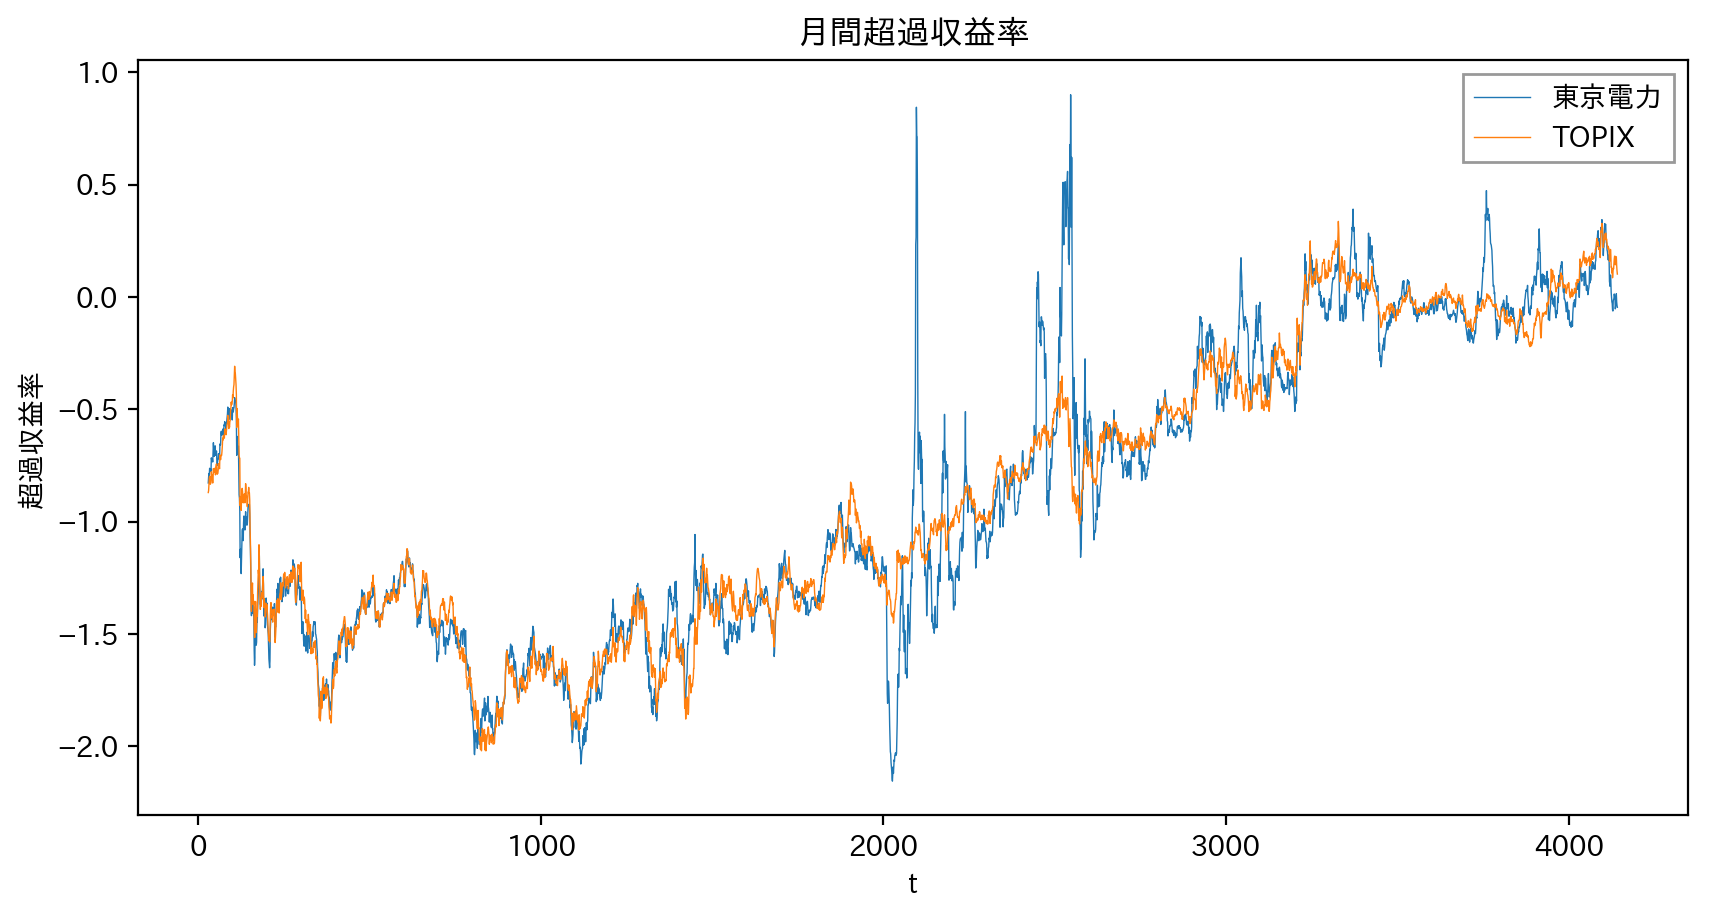

In [40]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"月間超過収益率")
plt.plot(x, linewidth=0.5, label="東京電力")
plt.plot(excess_return, linewidth=0.5, label="TOPIX")
plt.legend(edgecolor="gray", fancybox=False)
plt.xlabel('t')
plt.ylabel(r'超過収益率')
plt.savefig("excess_return_series.png")

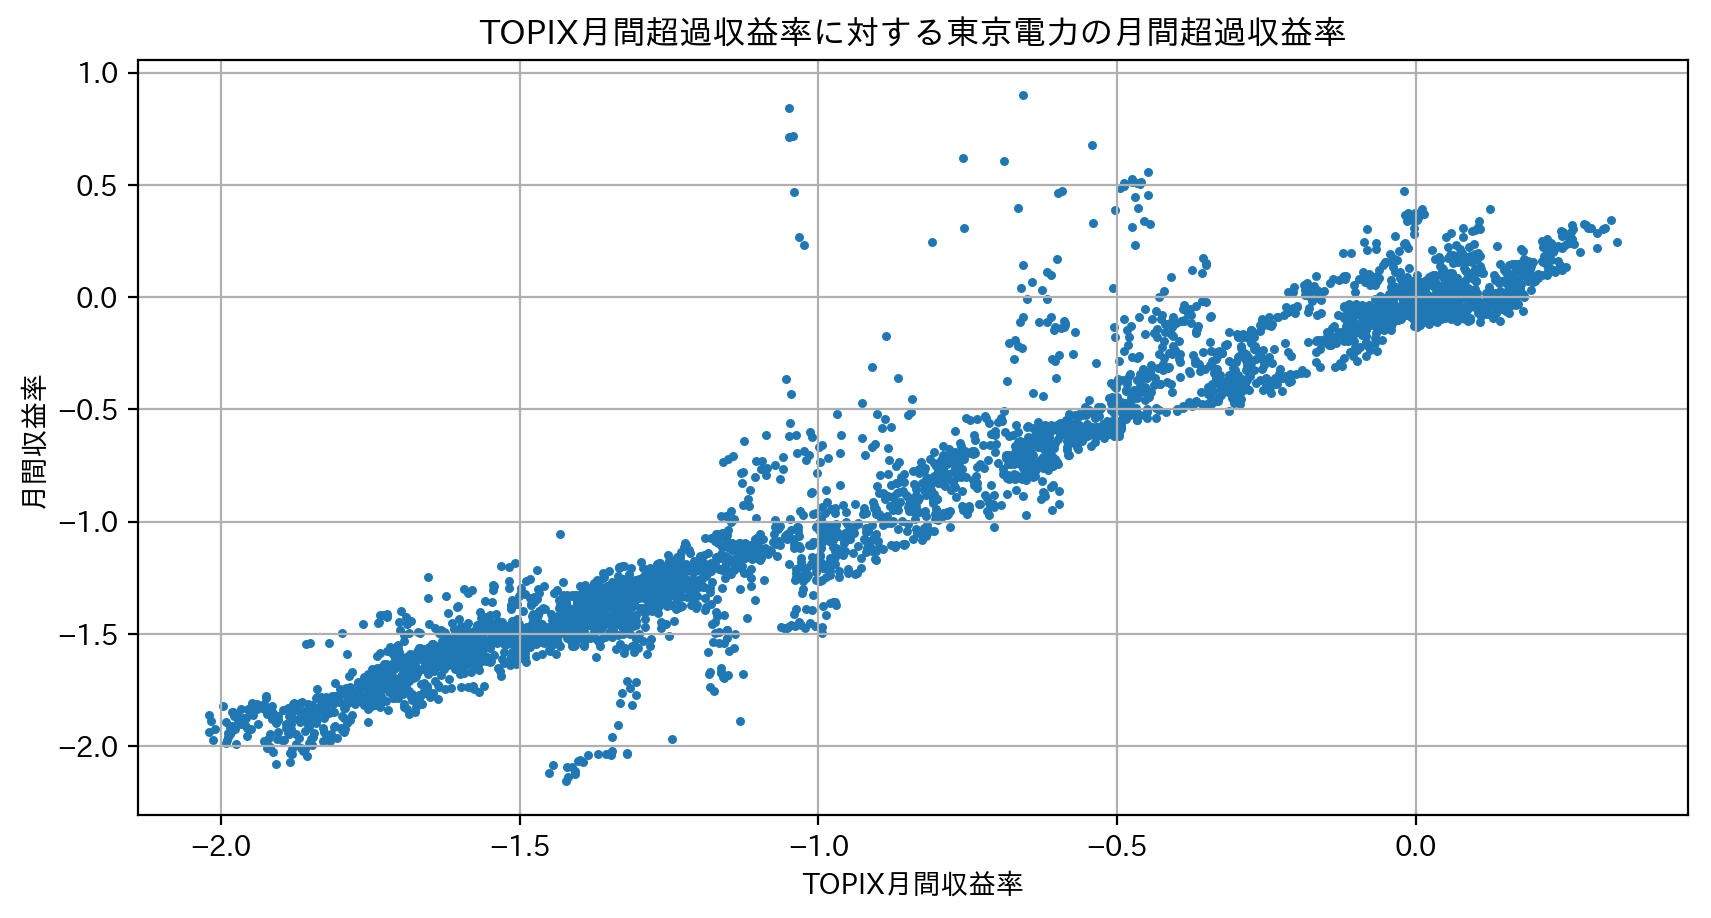

In [41]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"TOPIX月間超過収益率に対する東京電力の月間超過収益率")
plt.scatter(df["TOPIX月間利益率"][30:]-df["金利"][30:],df["月間収益率"][30:]-df["金利"][30:], s=5)
plt.xlabel('TOPIX月間収益率')
plt.ylabel('月間収益率')
plt.grid()
plt.savefig("excess_return_scatter.png")
plt.show()

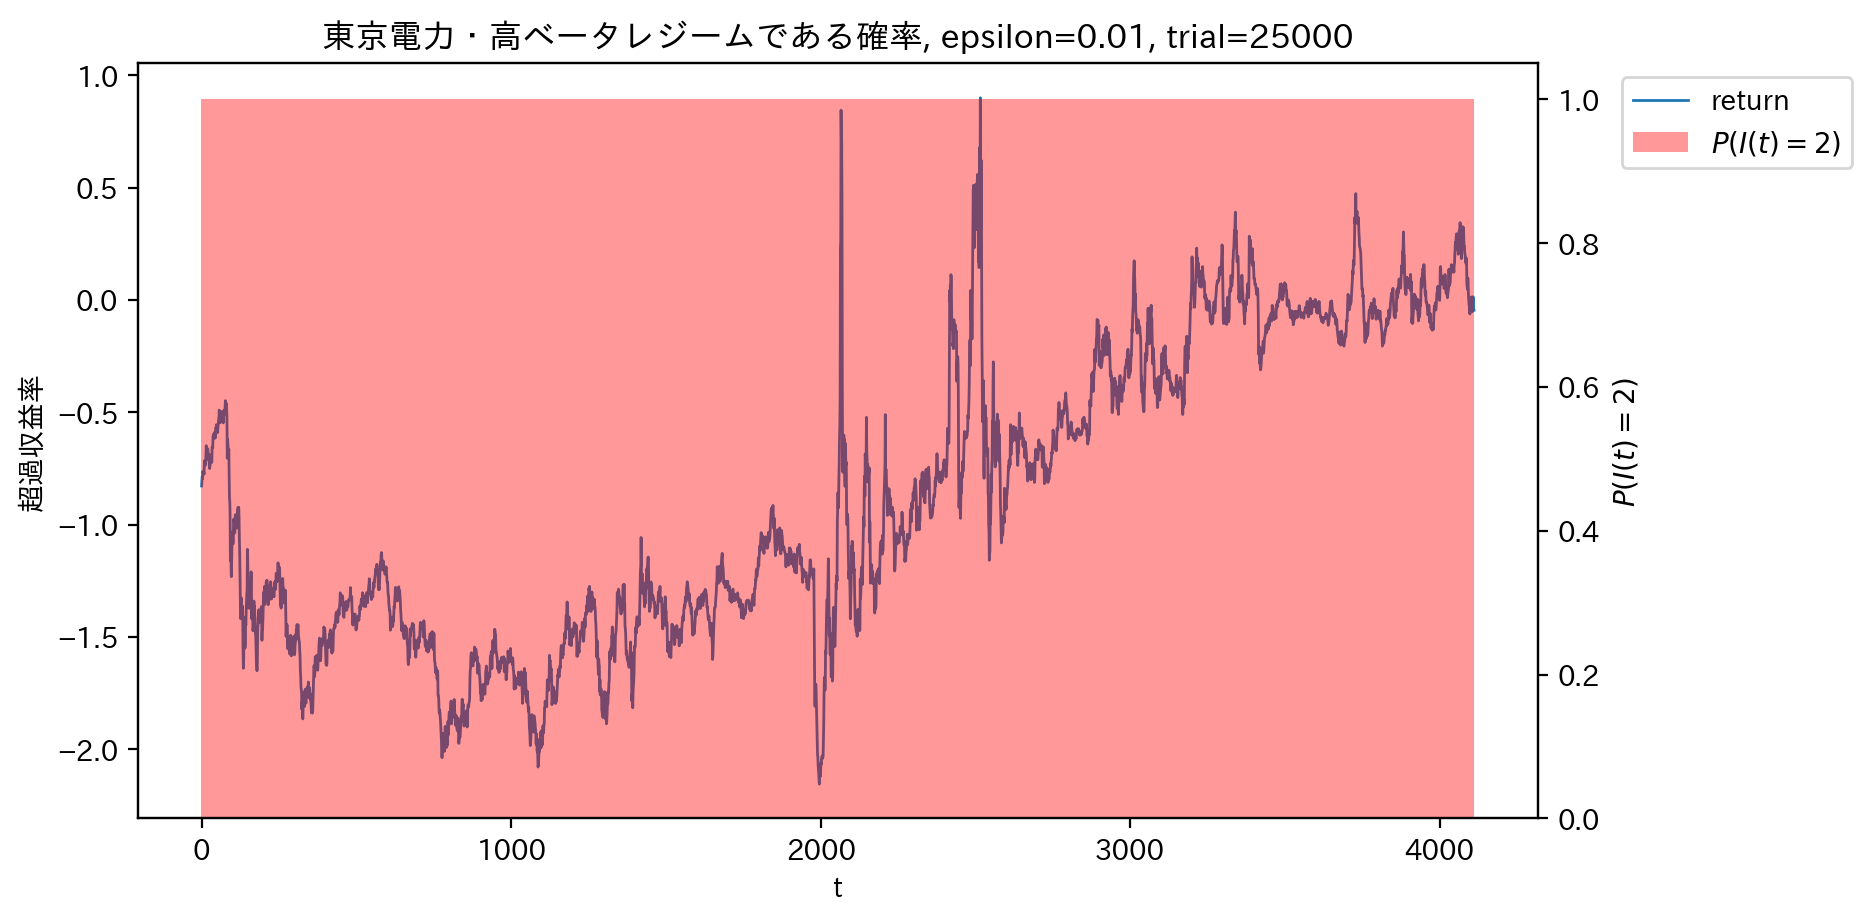

In [42]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), x, linewidth = 1.0, label="return")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), prob2, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('t')
ax1.set_ylabel(r'超過収益率')
ax2.set_ylabel(r'$P(I(t) = 2)$')
ax1.set_title(f"東京電力・高ベータレジームである確率, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("probability_regime2.png")
plt.show()

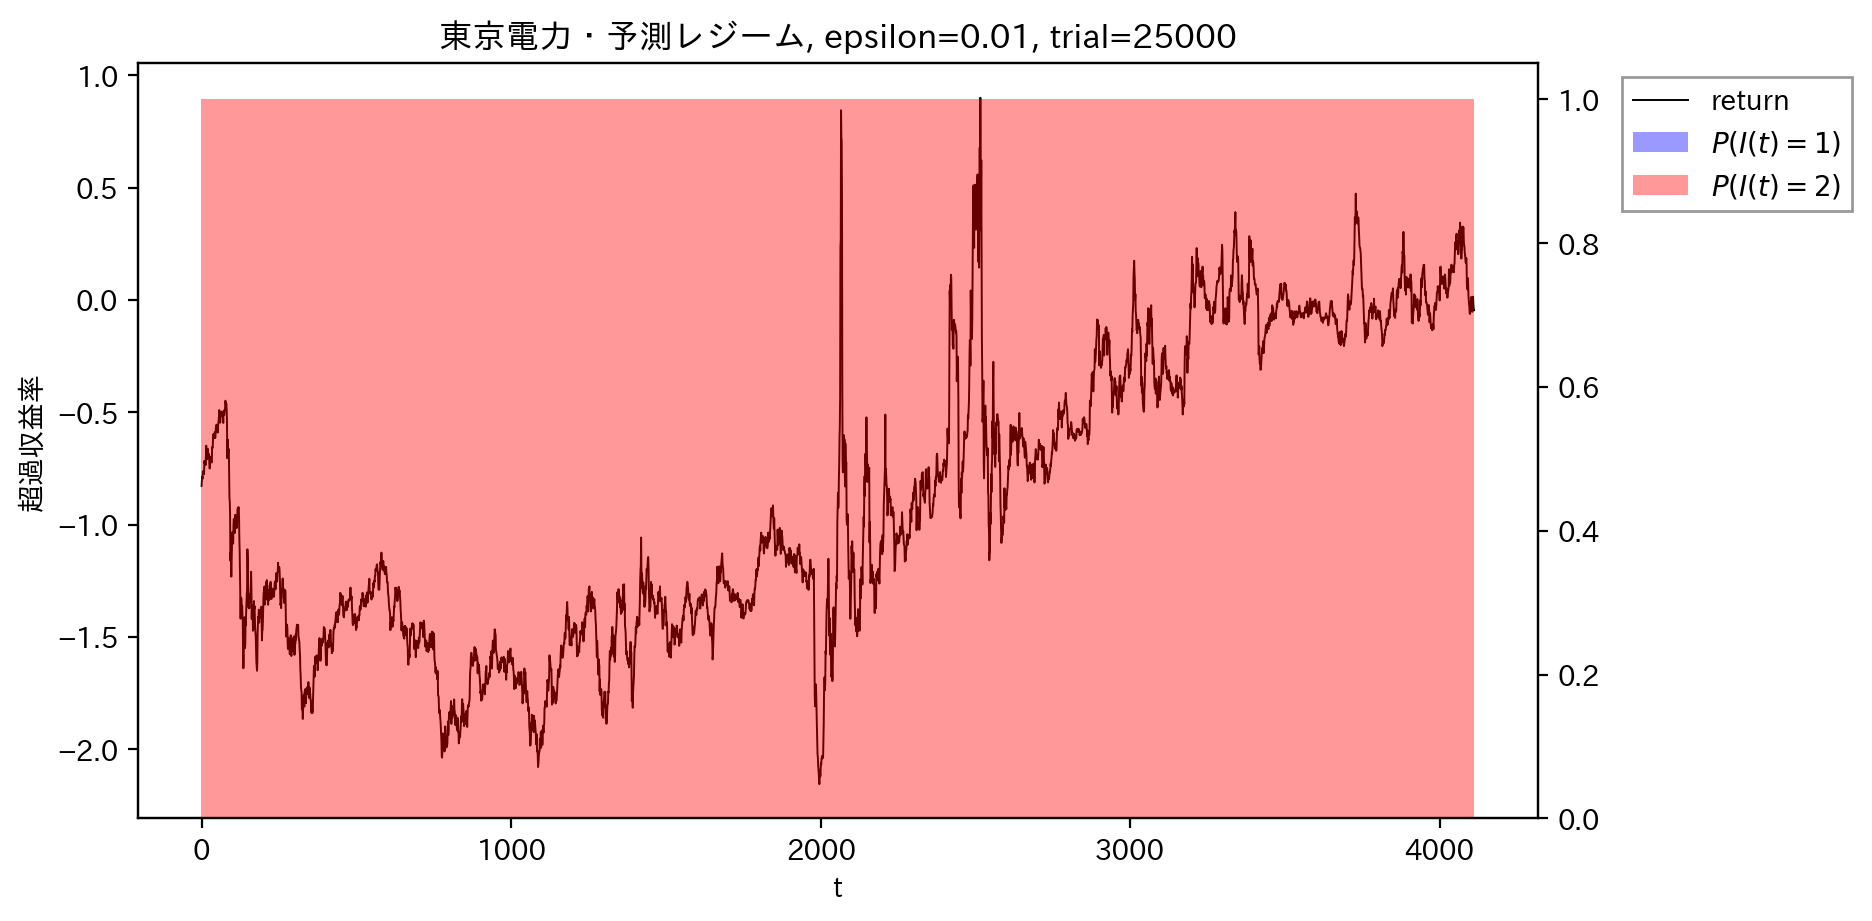

In [43]:
regime = np.array(prob2)>=0.5
regime = regime.astype(int)

fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), x, linewidth=0.7, color="black", label="return")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

ax1.set_xlabel('t')
ax1.set_ylabel(r'超過収益率')
ax1.set_title(f"東京電力・予測レジーム, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("estimated_regime_with_return.png")
plt.show()

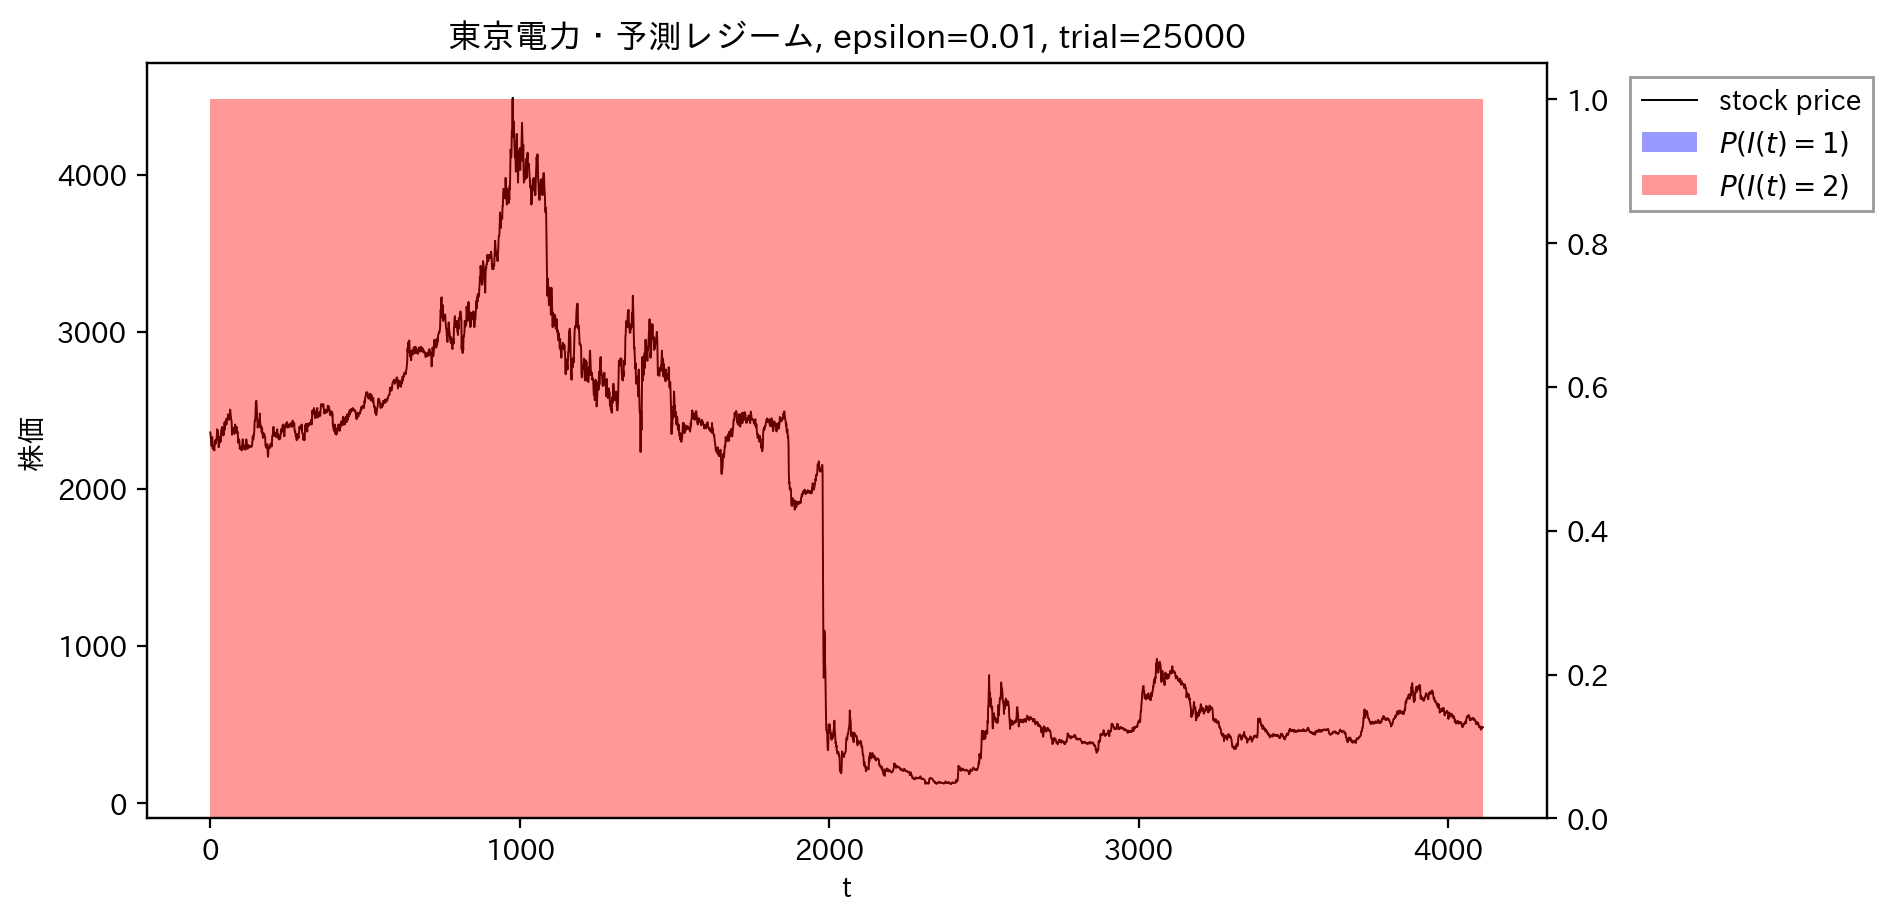

In [44]:
regime = np.array(prob2)>=0.5
regime = regime.astype(int)

fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), df["終値調整値"][30:], linewidth=0.7, color="black", label="stock price")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

ax1.set_xlabel('t')
ax1.set_ylabel(r'株価')
ax1.set_title(f"東京電力・予測レジーム, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("estimated_regime_with_price.png")
plt.show()

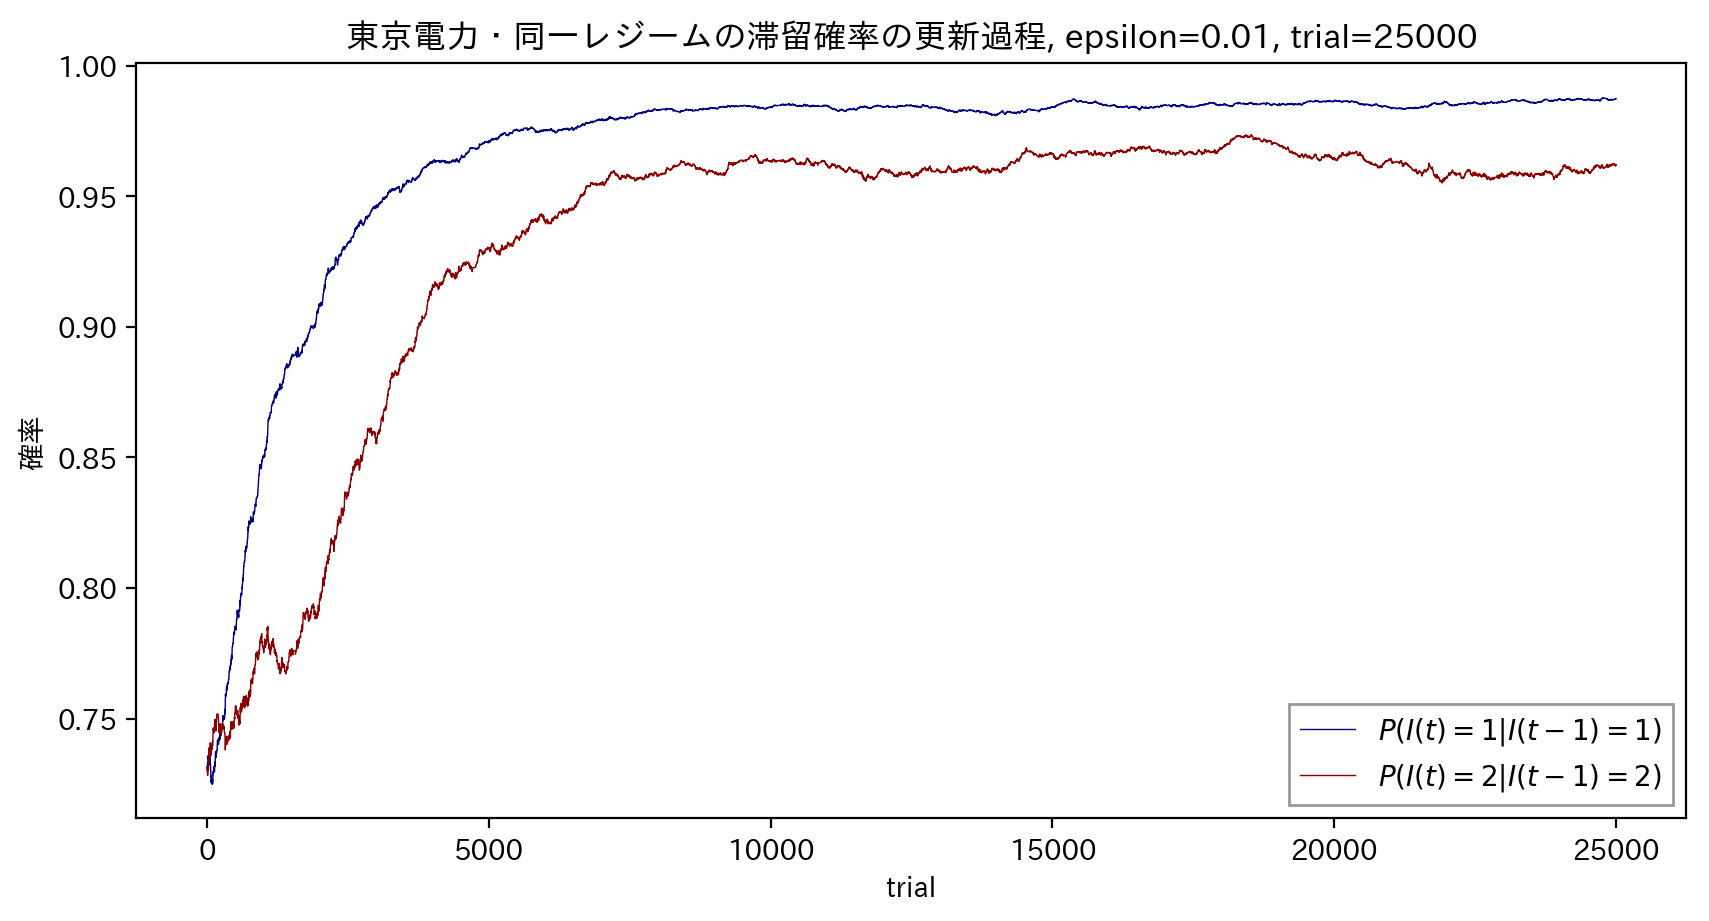

In [45]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,6], linewidth=0.5, color="navy", label=r"$P(I(t) = 1 | I(t-1) = 1)$")
ax1.plot(theta_list[:,7], linewidth=0.5, color="darkred", label=r"$P(I(t) = 2 | I(t-1) = 2)$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"東京電力・同一レジームの滞留確率の更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'確率')

plt.savefig("updating_probability.png")
plt.show()

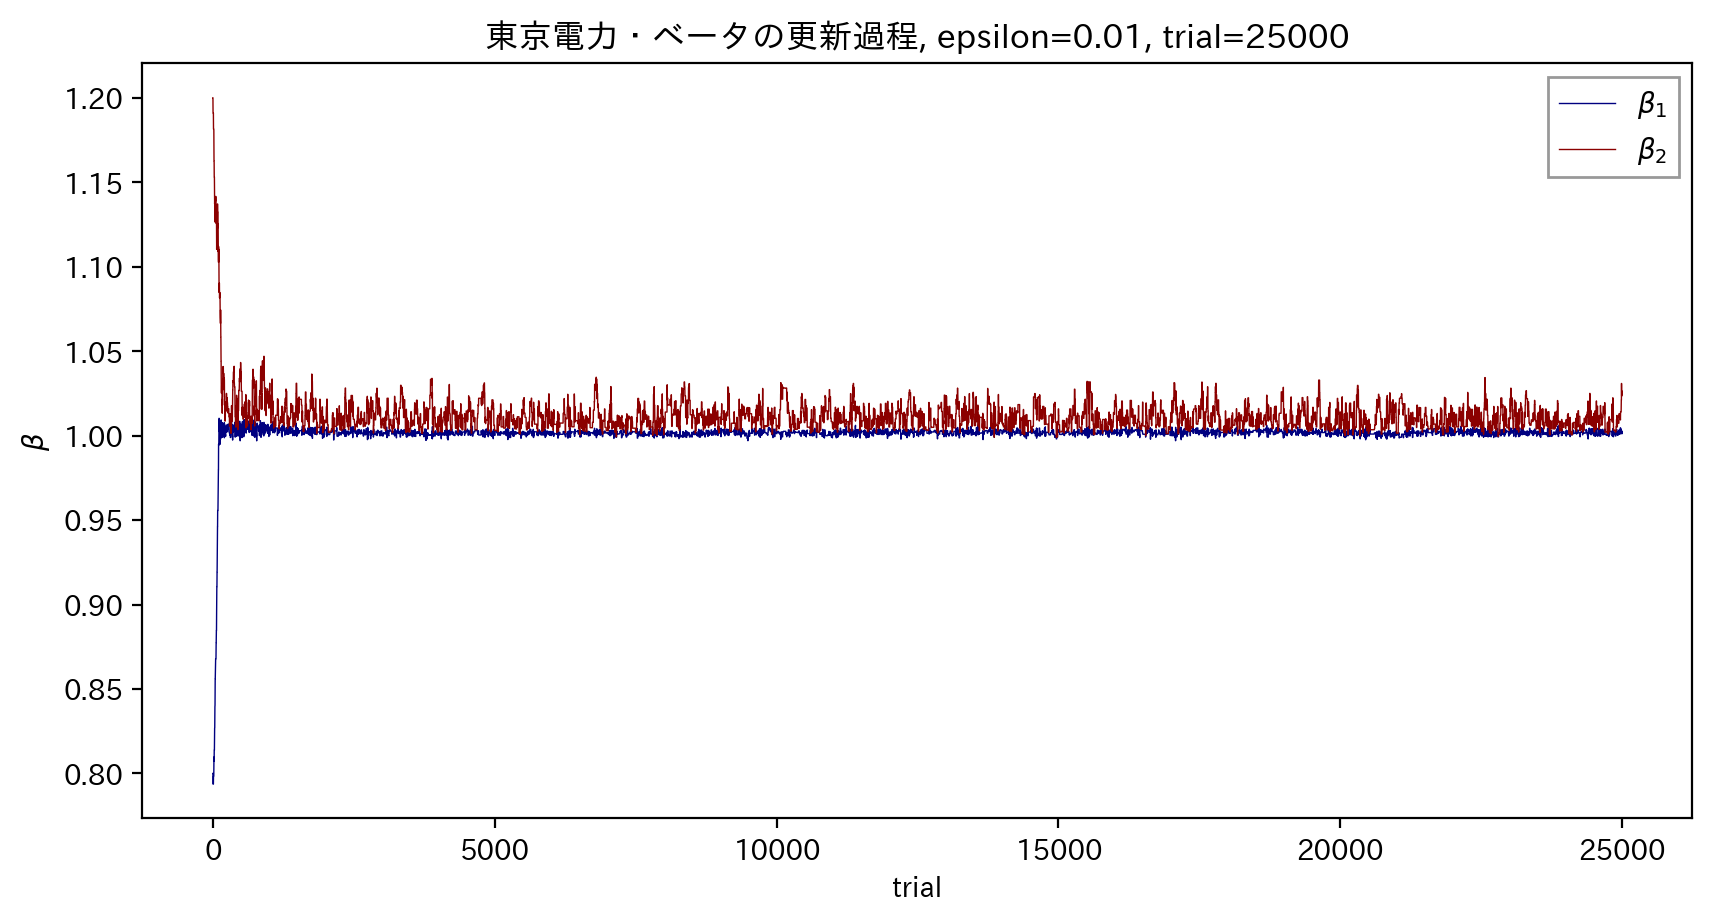

In [46]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,0], linewidth=0.5, color="navy", label=r"$\beta_1$")
ax1.plot(theta_list[:,1], linewidth=0.5, color="darkred", label=r"$\beta_2$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"東京電力・ベータの更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'$\beta$')

plt.savefig("updating_mu.png")
plt.show()

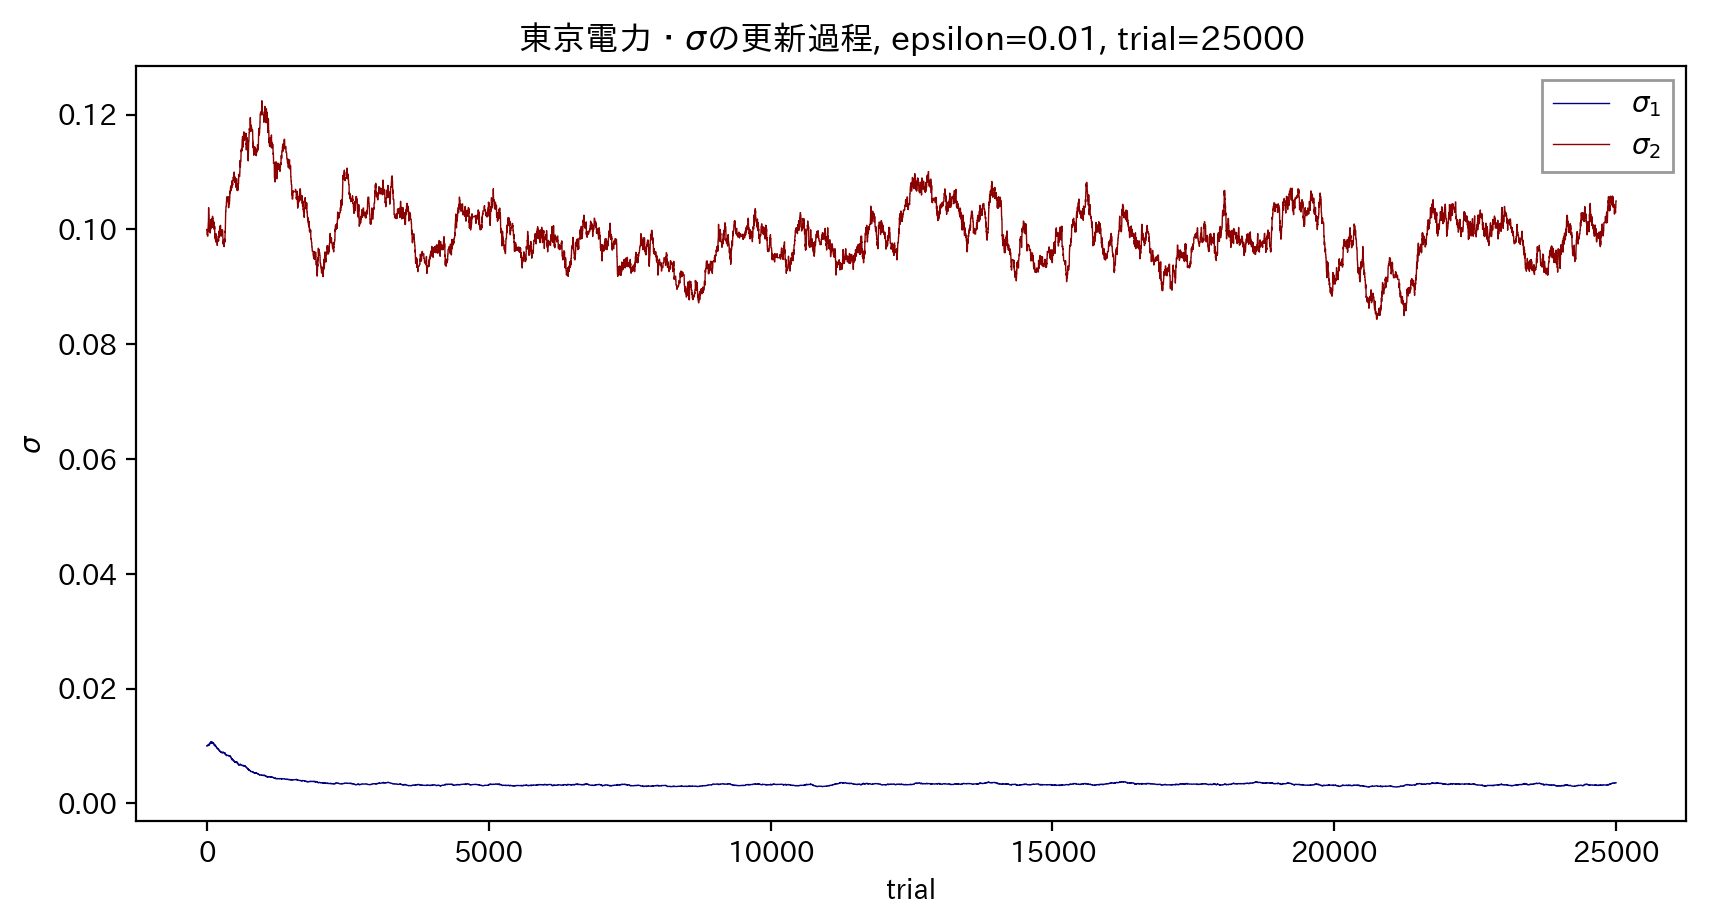

In [47]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,2], linewidth=0.5, color="navy", label=r"$\sigma_1$")
ax1.plot(theta_list[:,3], linewidth=0.5, color="darkred", label=r"$\sigma_2$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"東京電力・$\sigma$の更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'$\sigma$')

plt.savefig("updating_sigma.png")
plt.show()

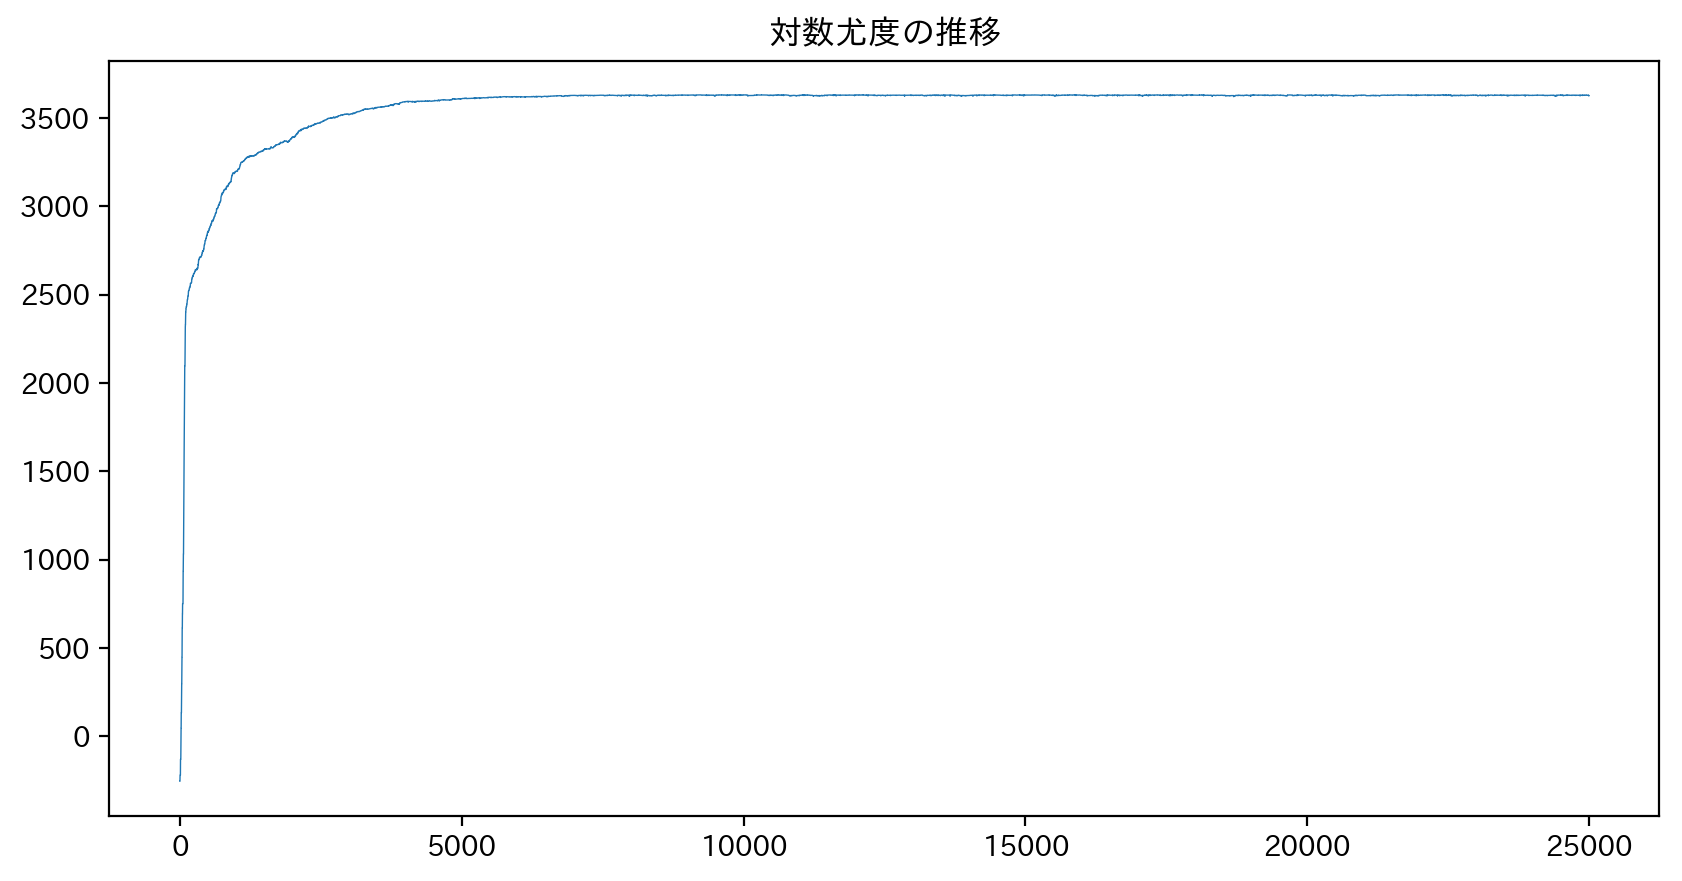

In [50]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(logL_list, linewidth=0.5)
ax1.set_title(f"対数尤度の推移")
plt.savefig("likelihood.png")
plt.show()